# Quit or stay?
## Goal

You belong to the people analytics team for a food conglomerate. Employee turnover has been rampant for your 10 subsidiaries. The CFO estimates that the cost of replacing an employee is often larger than 100K USD, taking into account the time spent to interview and find a replacement, placement fees, sign-on bonuses and the loss of productivity for several months.

Your team has been tasked with diagnosing why and when employees from your subsidiaries leave. You need a tangible data-driven recommendation for each of the ten Presidents of your subsidiaries. What are your recommendations and why?
## Details

We got employee data from a few companies. We have data about all employees who joined from 2011/01/24 to 2015/12/13. For each employee, we also know if they are still at the company as of 2015/12/13 or they have quit. Beside that, we have general info about the employee, such as average salary during her tenure, department, and years of experience. As said above, the goal is to predict employee retention and understand its main drivers
Data

## Approches

* Logistic Regression Classifier
* Random Forest Classifier
* XGBoost based classifier
* T-testing



## Data fields:

    * employee_id : id of the employee (unique by employee per company)
    * company_id : company id
    * dept : employee department
    * seniority : number of yrs of work experience when hired
    * salary: average yearly salary of the employee during her tenure within the company
    * join_date: when the employee joined the company, it can only be between 2011/01/24 and 2015/12/13
    * quit_date: when the employee left her job (if she is still employed as of 2015/12/13, this field is NA)



# 1. EDA

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('employee_retention.txt', sep=',', index_col=0)

In [3]:
df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,1001444.0,8,temp_contractor,0,5850.0,2008-01-26,2008-04-25
1,388804.0,8,design,21,191000.0,05.17.2011,2012-03-16
2,407990.0,3,design,9,90000.0,2012-03-26,2015-04-10
3,120657.0,2,engineer,20,298000.0,2013-04-08,2015-01-30
4,1006393.0,1,temp_contractor,0,8509.0,2008-07-20,2008-10-18


## 1.1 Check how many employees for each companies

In [4]:
df.company_id.value_counts()

1     9501
2     5220
3     3773
4     3066
5     2749
6     2258
7     2185
8     2026
9     2005
10    1879
12      24
11      16
Name: company_id, dtype: int64

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
def frequent_table(series, fig_title, x_label, y_label, rotate):
    series.plot.hist(grid=True, bins=12, rwidth=0.8,
                     color='#607c8e')
    plt.title(fig_title, fontsize=20)
    plt.xlabel(x_label, fontsize=20)
    plt.xticks(fontsize=20 ,rotation = rotate)
    plt.yticks(fontsize=20)
    plt.ylabel(y_label, fontsize=20)
    # plt.xlim(xmax=15, xmin=0)
    plt.grid(axis='y', alpha=1)

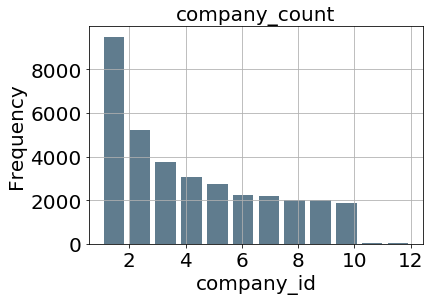

In [7]:
frequent_table(series = df.company_id, fig_title='company_count', x_label = 'company_id', y_label='Frequency', rotate = 0)

* Seems company 11 and 12 are not right. drop the rows.

In [8]:
df1 = df[(df.company_id != 11) & (df.company_id != 12)]

In [9]:
df1.company_id.value_counts()

1     9501
2     5220
3     3773
4     3066
5     2749
6     2258
7     2185
8     2026
9     2005
10    1879
Name: company_id, dtype: int64

## 1.2 Check employees in each department

In [10]:
df1.dept.value_counts()

temp_contractor     10000
customer_service     9162
engineer             4603
data_science         3184
sales                3170
marketing            3164
design               1379
Name: dept, dtype: int64

* We don't need the rows of temp_contractor. Drop it.

In [11]:
df2 = df1[(df1.dept != 'temp_contractor')]

In [12]:
df2.dept.value_counts()

customer_service    9162
engineer            4603
data_science        3184
sales               3170
marketing           3164
design              1379
Name: dept, dtype: int64

* We don't need employee_id column

In [13]:
df3 = df2.drop('employee_id', axis = 1)

## 1.3 Check employees' salary

In [14]:
df3.salary.isnull().sum()

238

In [15]:
df4= df3.copy()

* Fill null with mean salary. I use imputation. Missing values were replaced by the mean value of other employees grouped by department and seniority.

In [16]:
df4.salary = df3.salary.fillna(df3.groupby(['dept', 'seniority'])['salary'].transform("mean"))

In [17]:
df4.salary.isnull().sum()

0

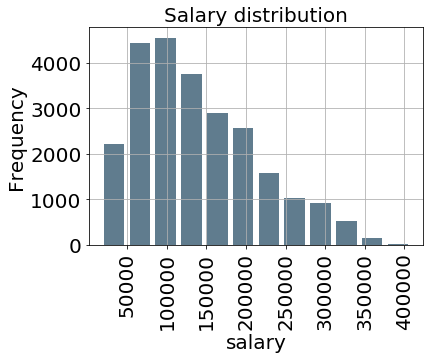

In [18]:
frequent_table(series = df4.salary, fig_title='Salary distribution', x_label = 'salary', y_label='Frequency', rotate = 90)

## 1.4 Check employees' join_data

In [19]:
df4.join_date[:10]

1     05.17.2011
2     2012-03-26
3     2013-04-08
5     2014-06-30
6     2012-07-02
7     12.27.2011
8     12.23.2013
9     2015-07-01
10    2015-08-03
11    2011-10-03
Name: join_date, dtype: object

In [20]:
df4.join_date.isnull().sum()

0

In [21]:
import datetime as dt

* join_date has two formats. assign the columns as DataTime

In [22]:
df4['cleaned_join_date'] = df4.join_date.apply(lambda x:dt.datetime.strptime(x,"%Y-%m-%d") if '-' in x else dt.datetime.strptime(x,"%m.%d.%Y"))

In [23]:
df4.cleaned_join_date.head(10)

1    2011-05-17
2    2012-03-26
3    2013-04-08
5    2014-06-30
6    2012-07-02
7    2011-12-27
8    2013-12-23
9    2015-07-01
10   2015-08-03
11   2011-10-03
Name: cleaned_join_date, dtype: datetime64[ns]

## 1.5 Check employees' quit_date

In [24]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24662 entries, 1 to 34701
Data columns (total 7 columns):
company_id           24662 non-null int64
dept                 24662 non-null object
seniority            24662 non-null int64
salary               24662 non-null float64
join_date            24662 non-null object
quit_date            13486 non-null object
cleaned_join_date    24662 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 1.5+ MB


* Seperate staying and quited emplyee first

In [25]:
df4['cleaned_quit_date'] = df4.quit_date.apply(lambda x:dt.datetime.strptime(x,"%Y-%m-%d") if type(x) != float else np.nan)

In [26]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24662 entries, 1 to 34701
Data columns (total 8 columns):
company_id           24662 non-null int64
dept                 24662 non-null object
seniority            24662 non-null int64
salary               24662 non-null float64
join_date            24662 non-null object
quit_date            13486 non-null object
cleaned_join_date    24662 non-null datetime64[ns]
cleaned_quit_date    13486 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(2), object(3)
memory usage: 1.7+ MB


In [27]:
df5 = df4.drop(['join_date','quit_date'], axis = 1)

In [28]:
df5['quit'] = df5.cleaned_quit_date.apply(lambda x: 0 if x != x  else 1)

In [53]:
df5.head()

,company_id,dept,seniority,salary,cleaned_join_date,cleaned_quit_date,quit,duration
1,8,design,21,191000.0,2011-05-17,2012-03-16,1,304.0
2,3,design,9,90000.0,2012-03-26,2015-04-10,1,1110.0
3,2,engineer,20,298000.0,2013-04-08,2015-01-30,1,662.0
5,5,marketing,20,180000.0,2014-06-30,NaT,0,NaN
6,3,customer_service,18,119000.0,2012-07-02,2014-03-28,1,634.0


* If stay, I set cleaned_quit_date as 2015-12-13.

In [56]:
df5.cleaned_quit_date = df5.cleaned_quit_date.apply(lambda x: dt.datetime(2015, 12, 13))

In [57]:
df5['duration'] = df5.cleaned_quit_date - df5.cleaned_join_date

In [58]:
df5.duration = df5.duration.apply(lambda x: x.days)

In [60]:
df5.head()

,company_id,dept,seniority,salary,cleaned_join_date,cleaned_quit_date,quit,duration
1,8,design,21,191000.0,2011-05-17,2015-12-13,1,1671
2,3,design,9,90000.0,2012-03-26,2015-12-13,1,1357
3,2,engineer,20,298000.0,2013-04-08,2015-12-13,1,979
5,5,marketing,20,180000.0,2014-06-30,2015-12-13,0,531
6,3,customer_service,18,119000.0,2012-07-02,2015-12-13,1,1259


## 1.6 Check employees' seniority

In [61]:
df5.seniority.value_counts()

8     1007
12     987
6      950
9      941
2      940
16     935
5      934
7      928
10     925
11     923
14     919
15     911
19     909
4      893
17     892
13     892
3      876
18     870
1      859
20     841
23     783
21     781
22     763
24     743
25     713
26     693
27     642
29     626
28     584
99       1
98       1
Name: seniority, dtype: int64

seniority levels that 98 and 99 doesn't look right. Drop them.

In [62]:
df6 = df5[(df5.seniority != 99) & (df5.seniority != 98)]

In [63]:
df6['salary_seniority'] = (df6.salary / df6.seniority)

/home/xinda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [64]:
df6.salary_seniority = df6.salary_seniority.apply(lambda x: round(x))

/home/xinda/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [65]:
df6.columns.values.tolist()

['company_id',
 'dept',
 'seniority',
 'salary',
 'cleaned_join_date',
 'cleaned_quit_date',
 'quit',
 'duration',
 'salary_seniority']

In [66]:
def cut_series(series, bin_num, series_max, series_min):
    MAX = series_max
    MIN = series_min
    series_cut = pd.cut(series, bins=[x for x in range(int(MIN), int(MAX), int((MAX-MIN)/bin_num))], include_lowest=True)
    series_cut = series_cut.value_counts(sort=False)
    return series_cut

In [67]:
def plot_overview(df):
    df_quit = df[df.quit == 1]
    df_stay = df[df.quit == 0]
    fig, ax = plt.subplots(1,6, figsize=(20, 6))
    plt.subplots_adjust(wspace = 0.3)
    ax_num = 0
    for i in ['company_id','dept']: # categorical value
        df_temp1 = df_quit.groupby(i).count()[['salary']].rename(columns={"salary": "quit"})
        df_temp2 = df_stay.groupby(i).count()[['salary']].rename(columns={"salary": "stay"})
        result = pd.concat([df_temp1, df_temp2], axis=1, join='inner')
        result.plot.bar(ax = ax[ax_num])
        ax_num += 1
    for i in ['seniority','salary','salary_seniority', 'duration']: # numerical value
        df_temp1 = cut_series(df_quit[i], 10, df_quit[i].max(), df_quit[i].min()).rename(columns={"seniority": "quit"})
        df_temp2 = cut_series(df_stay[i], 10, df_quit[i].max(), df_quit[i].min()).rename(columns={"seniority": "stay"})
        result = pd.concat([df_temp1, df_temp2], axis=1, join='inner').rename(columns={0: "quit", 1:"stay" })
        result.plot.bar(ax = ax[ax_num])
        ax[ax_num].set_xlabel(i)
        ax_num += 1

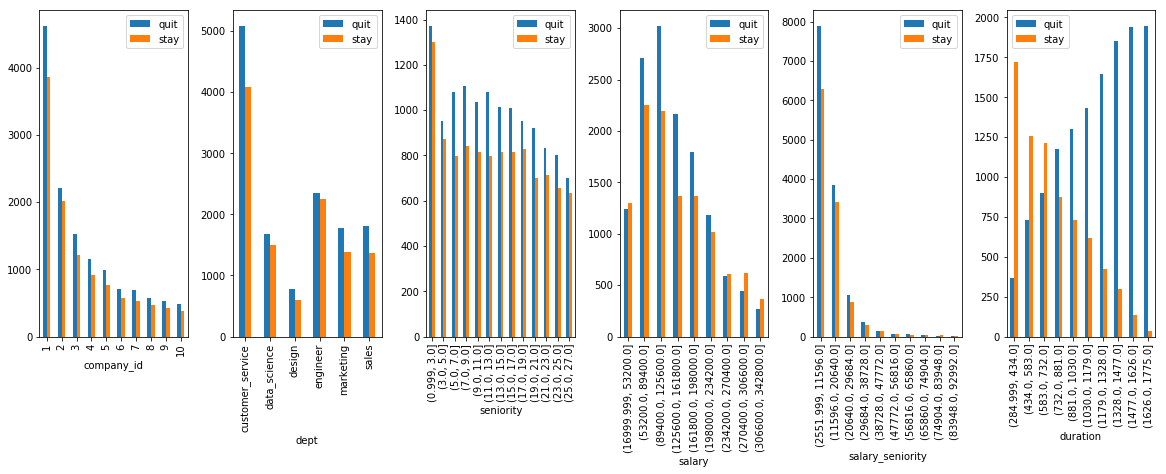

In [68]:
plot_overview(df6)

* Seems only duration matters

In [69]:
overview ='''
old_version of overall plot
def overview(df):
    fig, ax = plt.subplots(1,5, figsize=(20, 6))
    plt.subplots_adjust(wspace = 0.3)
    df.company_id.plot.hist(ax=ax[0], title = 'company_id')
    df.groupby(['dept','quit'])[['dept']].count().rename(columns={"dept": "count"}).sort_values(by = 'count', axis=0, ascending=False).plot(ax=ax[1], kind = 'bar', ylim = (0,8000), title = 'dept')
    df.seniority.plot.hist(ax=ax[2], title = 'seniority', ylim = (0,10000), xlim = (0,30))
    df.salary.plot.hist(ax=ax[3], title = 'salary', ylim = (0,5000), xlim = (0,400000))
    df.groupby(df["cleaned_join_date"].dt.year)[['cleaned_join_date']].count().rename(columns={"cleaned_join_date": "count"}).sort_values(by = 'count', axis=0, ascending=False).plot(ax=ax[4], kind = 'bar', ylim = (0,5000), title = 'join_date')
'''

# 2. Classifier

* Inspect label balance

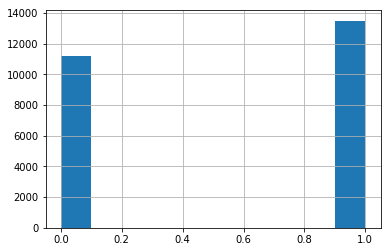

In [70]:
df6.quit.hist()

# 2.1 Logistic Regression Classifier

* Convert Categorical columns into binary data by one-hot encoding

In [71]:
df7 = df6.copy()

In [72]:
df7 = pd.get_dummies(df7, columns=['dept'], prefix=['dept'])

In [73]:
df7.head()

,company_id,seniority,salary,cleaned_join_date,cleaned_quit_date,quit,duration,salary_seniority,dept_customer_service,dept_data_science,dept_design,dept_engineer,dept_marketing,dept_sales
1,8,21,191000.0,2011-05-17,2015-12-13,1,1671,9095,0,0,1,0,0,0
2,3,9,90000.0,2012-03-26,2015-12-13,1,1357,10000,0,0,1,0,0,0
3,2,20,298000.0,2013-04-08,2015-12-13,1,979,14900,0,0,0,1,0,0
5,5,20,180000.0,2014-06-30,2015-12-13,0,531,9000,0,0,0,0,1,0
6,3,18,119000.0,2012-07-02,2015-12-13,1,1259,6611,1,0,0,0,0,0


In [74]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
from sklearn.linear_model import LogisticRegression

In [76]:
X = df7[['seniority',
         'salary', 
         'duration',
         'salary_seniority',
         'dept_customer_service',
         'dept_data_science',           
         'dept_design',
         'dept_engineer',
         'dept_marketing',
         'dept_sales']]

In [77]:
y = df7['quit']

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42, stratify=y)

In [75]:
lr = LogisticRegression(solver='lbfgs', random_state=42)

In [79]:
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [81]:
log_model = pd.DataFrame(lr.coef_,columns=X.columns)
log_model

,seniority,salary,duration,salary_seniority,dept_customer_service,dept_data_science,dept_design,dept_engineer,dept_marketing,dept_sales
0,-0.084643,-8.041191e-07,0.003051,-0.000073,-0.009076,0.001377,-0.000375,0.001769,-0.000771,-0.000684


In [84]:
y_pred_lr = lr.predict(X_test)
y_score_lr = lr.predict_proba(X_test)[:,1]

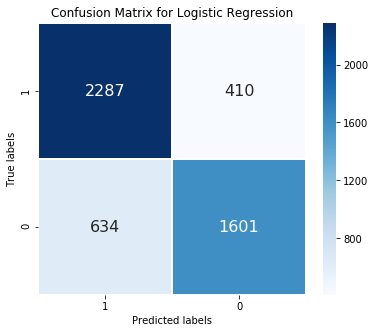

In [86]:
import seaborn as sns
lr_cm = confusion_matrix(y_test, y_pred_lr, labels=[1, 0])

f, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(lr_cm, annot=True, fmt='d', linewidths=.5, ax=ax, xticklabels=[1,0], yticklabels=[1, 0], annot_kws={'size':16},cmap=plt.cm.Blues)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix for Logistic Regression')
plt.show()

In [87]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.80      0.72      0.75      2235
           1       0.78      0.85      0.81      2697

   micro avg       0.79      0.79      0.79      4932
   macro avg       0.79      0.78      0.78      4932
weighted avg       0.79      0.79      0.79      4932



In [89]:
fpr_lr,tpr_lr,thresholds_lr = roc_curve(y_test,y_score_lr)

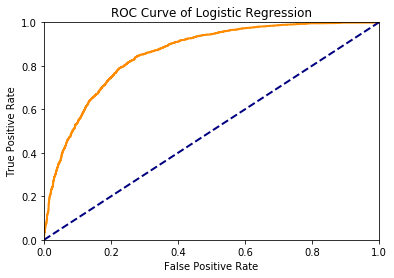

In [90]:
plt.plot(fpr_lr,tpr_lr,color='darkorange',lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim(0,1)
plt.ylim(0,1)
plt.title('ROC Curve of Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

# 2.2 Random Forest Classifier

* Bulid a tree based methods which will provide good explainibility on feature importance

In [91]:
from sklearn.ensemble import RandomForestClassifier

In [92]:
parameters = {'n_estimators': [50, 100, 200],
              'max_depth': [3, 6]
              }
rf_estimator = RandomForestClassifier(random_state=42)

clf = GridSearchCV(rf_estimator, param_grid=parameters,
                   scoring='accuracy', cv=5)

In [93]:
clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [50, 100, 200], 'max_depth': [3, 6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [94]:
rf = clf.best_estimator_

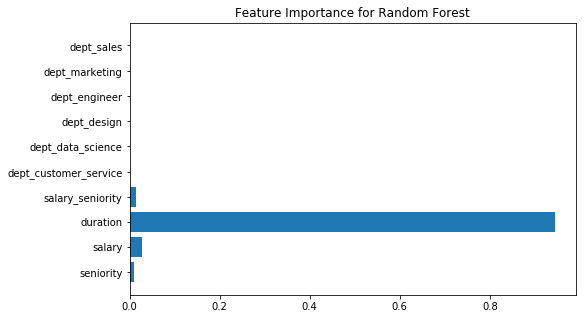

In [95]:
ax = plt.figure(figsize=[8, 5])
plt.barh(X.columns.values, rf.feature_importances_)
plt.title('Feature Importance for Random Forest')
plt.show()

In [96]:
y_pred_rf = rf.predict(X_test)
y_score_rf = rf.predict_proba(X_test)[:,1]

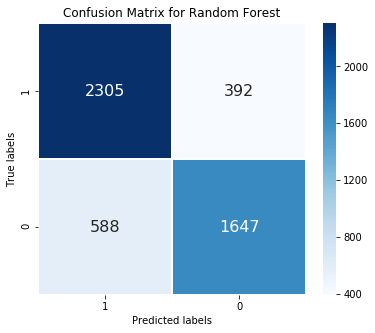

In [98]:
rf_cm = confusion_matrix(y_test, y_pred_rf, labels=[1, 0])

f, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(rf_cm, annot=True, fmt='d', linewidths=.5, ax=ax, xticklabels=[
            1,0], yticklabels=[1, 0], annot_kws={'size':16},cmap=plt.cm.Blues)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix for Random Forest')
plt.show()

In [99]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.81      0.74      0.77      2235
           1       0.80      0.85      0.82      2697

   micro avg       0.80      0.80      0.80      4932
   macro avg       0.80      0.80      0.80      4932
weighted avg       0.80      0.80      0.80      4932



In [100]:
fpr_rf,tpr_rf,thresholds_rf = roc_curve(y_test,y_score_rf)

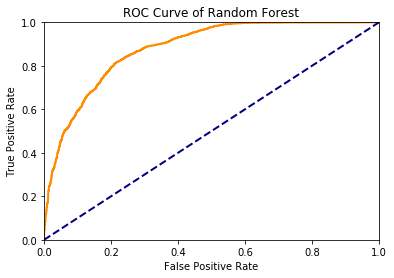

In [101]:
plt.plot(fpr_rf,tpr_rf,color='darkorange',lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim(0,1)
plt.ylim(0,1)
plt.title('ROC Curve of Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

# 2.3 XGBoost based classifier

* Imporive the performance using boosted trees. https://www.kaggle.com/stuarthallows/using-xgboost-with-scikit-learn

In [103]:
import xgboost as xgb

In [104]:
param = {'n_estimators': [50, 100, 200],
         'max_depth': [3,5],
         'learning_rate': [0.01, 0.1]
         }

xgb_model = xgb.XGBClassifier(random_state=42)

xgb_clf = GridSearchCV(xgb_model, param_grid=param, scoring='accuracy', cv=5)

In [105]:
xgb_clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=42, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [50, 100, 200], 'max_depth': [3, 5], 'learning_rate': [0.01, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [106]:
xgb_clf.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=42, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [107]:
best_xgb = xgb_clf.best_estimator_

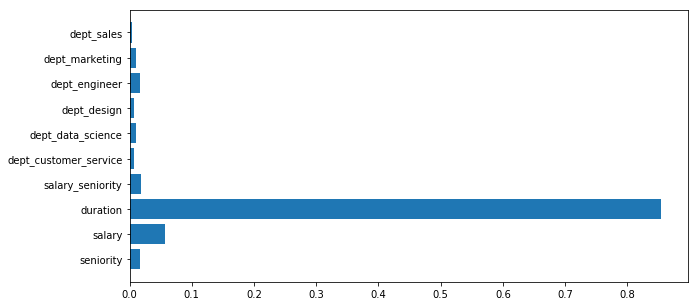

In [108]:
ax = plt.figure(figsize=[10, 5])
plt.barh(X.columns.values, best_xgb.feature_importances_)
plt.show()

In [109]:
y_pred_xgb = best_xgb.predict(X_test)
y_score_xgb = best_xgb.predict_proba(X_test)[:,1]

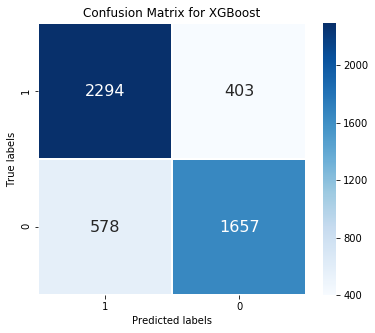

In [110]:
xgb_cm = confusion_matrix(y_test, y_pred_xgb, labels=[1, 0])

f, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(xgb_cm, annot=True, fmt='d', linewidths=.5, ax=ax, xticklabels=[
            1,0], yticklabels=[1, 0], annot_kws={'size':16},cmap=plt.cm.Blues)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix for XGBoost')
plt.show()

In [111]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.80      0.74      0.77      2235
           1       0.80      0.85      0.82      2697

   micro avg       0.80      0.80      0.80      4932
   macro avg       0.80      0.80      0.80      4932
weighted avg       0.80      0.80      0.80      4932



In [112]:
fpr_xgb,tpr_xgb,thresholds_xgb = roc_curve(y_test,y_score_xgb,drop_intermediate=True)

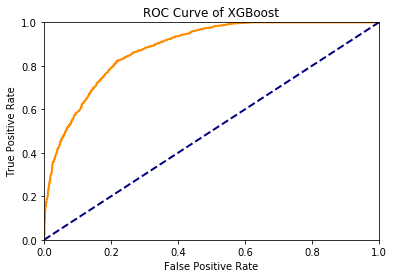

In [113]:
plt.plot(fpr_xgb,tpr_xgb,color='darkorange',lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim(0,1)
plt.ylim(0,1)
plt.title('ROC Curve of XGBoost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

<Figure size 720x360 with 0 Axes>

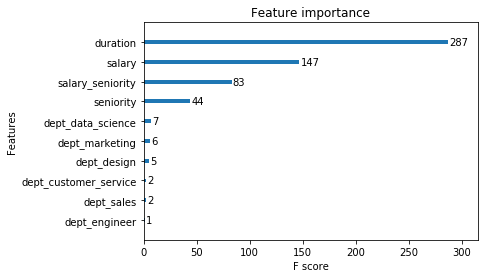

In [118]:
ax = plt.figure(figsize=[10, 5])
xgb.plot_importance(best_xgb,importance_type='weight',grid=False)
plt.show()

# 3. Post-predictive analytics

* Duration is the most important feature used in the classifiers.

In [126]:
df_quit = df7[df7.quit == 1]
df_stay = df7[df7.quit == 0]

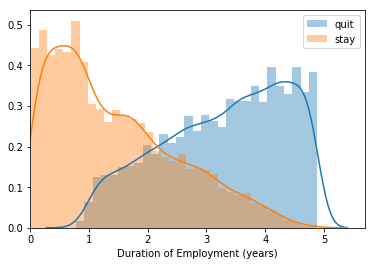

In [127]:
sns.distplot(df_quit.duration/365)
sns.distplot(df_stay.duration/365)
plt.legend(['quit','stay'])
plt.xlim(0,)
plt.xlabel('Duration of Employment (years)')
plt.show()

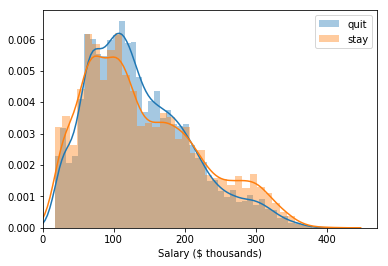

In [129]:
sns.distplot(df_quit.salary/1000)
sns.distplot(df_stay.salary/1000)
plt.legend(['quit','stay'])
plt.xlim(0,)
plt.xlabel('Salary ($ thousands)')
plt.show()

* salary, does not seem to be very different between classes. Let's see if we can confirm that understanding with a statistical test.

In [131]:
from scipy import stats
_,pvalue = stats.ttest_ind(df_quit.salary,df_stay.salary)
1-(1-pvalue/2)

3.815349813862667e-09

Given the p-value above, there is a significant difference between the salary of whom stay and quit. Those quitted has higher salary.